In [2]:
import pandas as pd 
import numpy as np
import plotly.express as px 
import plotly.graph_objects as go
import anndata as an

import sys, os 
sys.path.append('../src')

from model import *
from lightning_train import *
from data import *
from testing import *

In [30]:
primary = an.read_h5ad('../data/bhaduri/primary_T.h5ad', backed='r+')
organoid = an.read_h5ad('../data/bhaduri/organoid_T.h5ad', backed='r+')

In [37]:
prim_genes = [x.upper() for x in primary.var['index'].values]
org_genes = [x.upper() for x in organoid.var['index'].apply(lambda x: x.split('|')[0]).values]

In [39]:
len(set(prim_genes).intersection(org_genes))

16507

In [19]:
prim_labels = pd.read_csv('../data/bhaduri/primary_labels.tsv', sep='\t')
org_labels = pd.read_csv('../data/bhaduri/organoid_labels.tsv', sep='\t')

In [20]:
prim_labels['Subtype'].unique()

array(['oRG', 'Layer VI Occipital', 'Newborn', 'vRG', 'early', 'Mural',
       'IPC/newborn', 'OPC', 'Upper Layer Occipital', 'IPC-new',
       'Cajal Retzius', 'Upper Layer', 'Layer VI Pan-area', 'Outlier',
       'Microglia low quality', 'Low Quality', 'SST-MGE1', 'IPC-div1',
       'PFC', 'Upper Layer PFC', 'Microglia', 'Deep Layer', 'late',
       'Parietal and Temporal', 'IPC-div2', 'Layer IV', 'MGE2',
       'Endothelial', 'oRG/Astrocyte', 'tRG'], dtype=object)

In [21]:
org_labels['Subtype'].value_counts()

panRG                 69272
panNeuron             46665
lowquality            25224
glycolyticRG          19798
glycolyticneurons     16344
Newborn               14757
UpperLayer            12406
hindbrainRG            7670
earlyRG                5800
DeepLayer              4585
hindbrainAstrocyte     3565
MatureIPC              2210
Outlier                2160
Astrocyte              1873
Interneuron            1662
Unknown                1130
Name: Subtype, dtype: int64

## Label cleaning

Quickly, we'll remove labels we don't want to train on (that of low quality cells)

In [22]:
prim_labels = prim_labels[~prim_labels['Subtype'].isin(['Low Quality', 'Microglia low quality'])]

prim_labels.index.name = 'cell'
prim_labels = prim_labels.reset_index(drop=False)

prim_labels['Subtype'].unique()

array(['oRG', 'Layer VI Occipital', 'Newborn', 'vRG', 'early', 'Mural',
       'IPC/newborn', 'OPC', 'Upper Layer Occipital', 'IPC-new',
       'Cajal Retzius', 'Upper Layer', 'Layer VI Pan-area', 'Outlier',
       'SST-MGE1', 'IPC-div1', 'PFC', 'Upper Layer PFC', 'Microglia',
       'Deep Layer', 'late', 'Parietal and Temporal', 'IPC-div2',
       'Layer IV', 'MGE2', 'Endothelial', 'oRG/Astrocyte', 'tRG'],
      dtype=object)

In [48]:
org_labels = org_labels[~org_labels['Subtype'].isin(['lowquality'])]

org_labels.index.name = 'cell'
org_labels = org_labels.reset_index(drop=False)

org_labels

,cell,V1,Cluster,Sample,Line,Protocol,Age,iPSCorhESC,Class,State,Type,Subtype
0,0,H1SWeek3_AAACCTGAGACAAAGG,29,H1SWeek3,H1,Less Directed,3,hESC,Nonneuronal,Dividing,RadialGlia,panRG
1,1,H1SWeek3_AAACCTGAGCACACAG,5,H1SWeek3,H1,Less Directed,3,hESC,Nonneuronal,Dividing,RadialGlia,panRG
2,2,H1SWeek3_AAACCTGAGGATGGAA,35,H1SWeek3,H1,Less Directed,3,hESC,Nonneuronal,Dividing,RadialGlia,panRG
3,3,H1SWeek3_AAACCTGCAATTGCTG,36,H1SWeek3,H1,Less Directed,3,hESC,Nonneuronal,Nondividing,RadialGlia,hindbrainRG
4,4,H1SWeek3_AAACCTGCAGCGTAAG,5,H1SWeek3,H1,Less Directed,3,hESC,Nonneuronal,Dividing,RadialGlia,panRG
...,...,...,...,...,...,...,...,...,...,...,...,...
209892,235115,WTC10SWeek10_TTTGTCAAGGCCCTTG,2,YH10SWeek10,YH10,Less Directed,10,iPSC,Neuronal,Postmitotic,ExcitatoryNeuron,panNeuron
209893,235117,WTC10SWeek10_TTTGTCACAAGTTGTC,35,YH10SWeek10,YH10,Less Directed,10,iPSC,Nonneuronal,Nondividing,IPC,MatureIPC
209894,235118,WTC10SWeek10_TTTGTCAGTCTAAACC,2,YH10SWeek10,YH10,Less Directed,10,iPSC,Neuronal,Postmitotic,ExcitatoryNeuron,panNeuron
209895,235119,WTC10SWeek10_TTTGTCATCACAGGCC,4,YH10SWeek10,YH10,Less Directed,10,iPSC,Nonneuronal,Nondividing,RadialGlia,earlyRG


In [23]:
prim_labels.to_csv('../data/bhaduri/primary_labels_clean.csv', index=False)
org_labels.to_csv('../data/bhaduri/organoid_labels_clean.csv', index=False)

In [88]:
pd.read_csv('../data/bhaduri/primary_labels_clean.csv')['Subtype'].nunique()

28

## Predicting organoid cell types

In [3]:
from os.path import join

data_path = '../data/bhaduri/'

primary = an.read_h5ad(join(data_path, 'primary_T.h5ad'), backed='r+')
organoid = an.read_h5ad(join(data_path, 'organoid_T.h5ad'), backed='r+')

prim_genes = [x.upper() for x in primary.var['index'].values]
org_genes = [x.upper() for x in organoid.var['index'].apply(lambda x: x.split('|')[0]).values]
refgenes = list(set(prim_genes).intersection(org_genes))

module = DataModule(
    datafiles=[join(data_path, 'primary_T.h5ad')],
    labelfiles=[join(data_path, 'primary_labels_clean.csv')],
    class_label='Subtype',
    sep=',',
    batch_size=32,
    index_col='cell',
    num_workers=0,
    deterministic=True,
    normalize=True,
    assume_numeric_label=False,
    currgenes=prim_genes,
    refgenes=refgenes,
    preprocess=True,
)

module.prepare_data()
module.setup()

assume_numeric_label=False, using sklearn.preprocessing.LabelEncoder and encoding target variables.
Transforming labelfile 1/1
Creating train/val/test DataLoaders...
Done, continuing to training.
Calculating weights


In [4]:
model = SIMSClassifier.load_from_checkpoint(
    '../checkpoints/checkpoint-50-desc-bhaduri_primary_cortical_unweighted.ckpt',
    input_dim=module.input_dim,
    output_dim=module.output_dim,
    weights=module.weights,
    n_a=32,
    n_d=32,
    n_steps=10,
)

Initializing network
Initializing explain matrix


Now, we can load in the organoid data, generate a dataloader and make cell type predictions

In [5]:
organoid = an.read_h5ad(join(data_path, 'organoid_T.h5ad'))

to_pred = TestAnndatasetMatrix(organoid.X)

In [6]:
loader = DataLoader(to_pred, batch_size=64, num_workers=0)

next(iter(loader))

tensor([[0.0563, 0.0000, 0.4843,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7837, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [51]:
from tqdm import tqdm 

topk = []
with torch.no_grad():
    for i, X in enumerate(tqdm(loader)):
        X = clean_sample(
            sample=X,
            refgenes=refgenes,
            currgenes=org_genes,
        )

        res, _ = model(X)

        _, top_preds = res.topk(3, axis=1) # to get indices
        topk.extend(top_preds.numpy())

100%|█| 3674/3674 [39:15<00:00,  1.


In [52]:
topk = pd.DataFrame(topk)

topk

,0,1,2
0,27,24,13
1,6,24,16
2,24,22,5
3,7,21,19
4,8,18,13
...,...,...,...
235116,27,3,23
235117,22,24,6
235118,10,18,21
235119,27,23,4


In [53]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [54]:
prim_labels['Subtype'].unique()

array(['oRG', 'Layer VI Occipital', 'Newborn', 'vRG', 'early', 'Mural',
       'IPC/newborn', 'OPC', 'Upper Layer Occipital', 'IPC-new',
       'Cajal Retzius', 'Upper Layer', 'Layer VI Pan-area', 'Outlier',
       'SST-MGE1', 'IPC-div1', 'PFC', 'Upper Layer PFC', 'Microglia',
       'Deep Layer', 'late', 'Parietal and Temporal', 'IPC-div2',
       'Layer IV', 'MGE2', 'Endothelial', 'oRG/Astrocyte', 'tRG'],
      dtype=object)

In [61]:
le = le.fit(prim_labels['Subtype'])
topk.head()

,0,1,2
0,27,24,13
1,6,24,16
2,24,22,5
3,7,21,19
4,8,18,13


In [62]:
import plotly.express as px 

labels = pd.Series(le.inverse_transform(topk.loc[:, 0]))

fig = px.bar(labels.value_counts())

fig.update_layout(
    title='Distribution of Inferred Cell Types',
    font_family='Serif',
    xaxis_title='Cell Type',
    yaxis_title='Number of cells',
    showlegend=False
)

fig.write_image('../../ms-thesis/images/bhaduri-inferred-labels.pdf', scale=3)

In [87]:
first = pd.Series(le.inverse_transform(topk.loc[:, 0])).value_counts()
second = pd.Series(le.inverse_transform(topk.loc[:, 1])).value_counts()

fig = go.Figure(
    data=[
        go.Bar(x=first.index, y=first.values, name='First Predicted Label'),
#         go.Bar(x=second.index, y=second.values, name='Second Predicted Label')
    ]
)

fig.update_layout(
    title='Distribution of Inferred Cell Types',
    font_family='Serif',
    xaxis_title='Cell Type',
    yaxis_title='Number of cells',
#     showlegend=False,
    barmode='group'
)

fig.show()
fig.write_image('../../ms-thesis/images/bhaduri_inferred_labels.pdf', scale=3)

In [81]:
import plotly.express as px 

organoid_tsne = pd.read_csv('../data/bhaduri/organoid_tsne.tsv', sep='\t', header=None)

organoid_tsne = organoid_tsne.rename(columns={1: 'x', 2: 'y'})

In [59]:
labels = pd.read_csv('../data/bhaduri/organoid_labels_clean.csv')
org_labels['predicted'] = topk.loc[:, 0]

org_labels['predicted'].isna().sum()

0

In [67]:
import matplotlib.pyplot as plt 

plt.scatter(organoid_tsne[0], organoid_tsne[1], c=org_labels['predicted'].astype(int).values)

plt.show()


KeyboardInterrupt



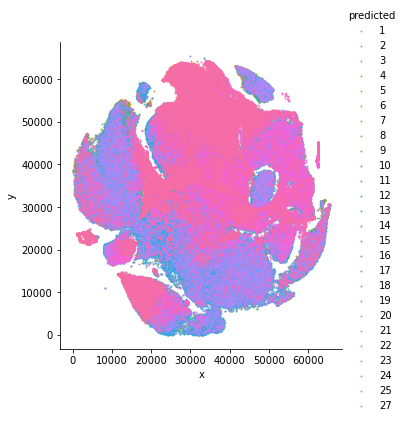

In [84]:
import seaborn as sns

organoid_tsne['predicted'] = topk.loc[:, 0]

sns.lmplot(x='x', y='y', data=organoid_tsne, hue='predicted', fit_reg=False, scatter_kws={"s": 1})